In [1]:
%matplotlib inline

import os
import json
import glob
from PIL import Image
import numpy as np

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
import cv2
import time
import pandas as pd

from matplotlib import pyplot as plt

In [2]:
def read_video(filename):
    cap = cv2.VideoCapture(filename)
    
    backSub = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=12)

    frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print(frameCount)
    buf = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))

    fc = 0
    ret = True

    while (fc < frameCount and ret):
        r, b = cap.read()
        if b is None:
            break
        else:
            fgMask = backSub.apply(b)
            fgMask = cv2.blur(fgMask, (25, 25))
            b[fgMask < 25] = 255
            ret, buf[fc] = r, b
            
        fc += 1

    cap.release()
    return buf[:fc]

In [3]:
def show_buffer(buf, outname='output.avi', show_it=True):
    width = buf.shape[2]
    height = buf.shape[1]
    if show_it:
        output_notebook()
        p = figure(x_range=(0,width), y_range=(0,height), output_backend="webgl", width=width//2, height=height//2)
        myImage = p.image_rgba(image=[buf[0]], x=0, y=0, dw=width, dh=height)
        show(p, notebook_handle=True)
    else:
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        out = cv2.VideoWriter(outname, fourcc, 60.0, (width, height))
    
    for i in range(len(buf)):
        frame = buf[i]
        
        if show_it:
            frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
            frame=cv2.flip(frame, 2)
            frame=cv2.flip(frame, -1)
            myImage.data_source.data['image']=[frame]
            push_notebook()
            time.sleep(0.00001)
        else:
            out.write(frame)
    if not show_it:
        out.release()

In [4]:
def extract_backgrounds():
    #indir = 'videos'
    #outdir = 'vids_no_bg/'
    indir = 'videos_mts/'
    outdir = 'vids_no_bg2'
    #for vid in glob.glob(os.path.join(indir, '*.avi')):
    for vid in glob.glob(os.path.join(indir, '*.MTS')):
        print(vid)
        vid_out = os.path.join(outdir, os.path.basename(vid))
        buf = read_video(vid)
        show_buffer(buf, vid_out, show_it=False)

#extract_backgrounds()
#show_buffer(read_video('AVCHD/BDMV/STREAM//00003.MTS'))

In [5]:
# some environment params
pt_start_fence = np.array((290, 858))
pt_end_fence = np.array((1270, 551))

fence_vec = pt_end_fence - pt_start_fence

incline = np.abs(fence_vec[1]) / np.abs(fence_vec[0]) *100

print("incline: %.2f%%"%(incline))

fence_pix_len = np.sqrt(sum(fence_vec**2))
fence_m_len = 3.43
meter_per_pixel = fence_m_len / fence_pix_len

incline: 31.33%


# run openpose

```bash
$ cd /home/tobi/Documents/openpose2
$ for f in $(ls ~/Dropbox/uni_koeln/ltc1_biomechanics/assignment3/vids_no_bg/*.avi); do echo ./build/examples/openpose/openpose.bin --video $f --write_json kpts; done
```

In [6]:
def pt_dist(a, b):
    return np.abs(np.sum(a - b))

def is_valid(pose, spread_thresh):
    mp = pose.reshape(25,3)
    # is cramped?
    if np.max(mp - np.mean(mp, 0)) < spread_thresh:
        return False
    # isn't tall enough?
    if (np.max(mp, 0) - np.min(mp, 0))[0] < 500:
        return False
    # not enough visible points:
    if sum(np.sum(mp, 1) == 0) > 15:
        return False
    return True
        

def read_pt_movement(vid_name, dist_thresh=150, spread_thresh=150):
    gs = glob.glob(os.path.join('kpts2', os.path.basename(vid_name).split('.')[0] + '*.json'))
    movement = []
    last_pose = None
    for g in sorted(gs):
        with open(g) as fh:
            kps = json.load(fh)
            peeps = kps['people']
            if len(peeps) > 0:
                if len(peeps) > 1:
                    min_dist = 1e10
                    min_ind = 0
                    for p_ix, p in enumerate(peeps):
                        this_pose = np.array(p['pose_keypoints_2d'])
                        if not is_valid(this_pose, spread_thresh):
                            continue

                        if last_pose is not None:
                            dist = pt_dist(this_pose, last_pose)
                            if dist < min_dist:
                                min_dist = dist
                                min_ind = p_ix
                    this_pose = np.array(peeps[min_ind]['pose_keypoints_2d'])
                else:
                    this_pose = np.array(peeps[0]['pose_keypoints_2d'])
                    
                if last_pose is not None:
                    dist = pt_dist(last_pose, this_pose) / 75.
                    #print(dist)
                    if dist > dist_thresh:
                        #last_pose = this_pose
                        continue
                        
                # check that the pose is realistic. points should be spread out.
                if not is_valid(this_pose, spread_thresh):
                    continue
                
                movement.append(this_pose)
                last_pose = this_pose
    return np.array(movement).reshape(-1, 25, 3)

In [7]:
# now determine, which body parts belongs to which point
# https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/output.md#keypoint-ordering-in-cpython

df_dempster = pd.read_csv('dempster_parameters.csv')

names = ['nose',
         'neck',
         'shoulder.right',
         'elbow.right',
         'wrist.right',
         'shoulder.left',
         'elbow.left',
         'wrist.left',
         'hip.center',
         'hip.right',
         'knee.right',
         'ankle.right',
         'hip.left',
         'knee.left',
         'ankle.left',
         'eye.right',
         'eye.left',
         'ear.right',
         'ear.left',
         'bigtoe.left',
         'smalltoe.left'
         'heel.left',
         'bigtoe.right',
         'smalltoe.right',
         'heel.right'
        ]
name_dict = {n: i for i, n in enumerate(names)}
         
display(df_dempster)

def smooth_all_pts(pts):
    # straighten it out!
    N, num_parts, dims = pts.shape

    # compute a 3 pts average.
    avgs = np.zeros((N, num_parts, 2))
    for i in range(num_parts):
        for j in range(1, N-1):
            # add all 3 up, divide by number of valid points
            subset = pts[j-1:j+2, i, :2]
            normalize = sum(np.sum(subset, 1) > 0)
            avgs[j, i, :2] = np.sum(subset, 0) / (normalize + 1e-6)
    return avgs[1:-1]

def center_of_mass_for_pc(pts):
    com = np.array([0., 0])
    weights = 0
    for _, row in df_dempster.iterrows():
        def add_to_center(prox, dist):
            nonlocal weights
            nonlocal com
            if sum(dist) == 0 or sum(prox) == 0:
                pass
            else:
                seg_center = prox + row['cm_ratio'] * (dist - prox)    
                com += seg_center * row['seg_weight']
                weights += row['seg_weight']
    
        if row['sides'] == 2:
            for lr in ['.left', '.right']:
                prox = pts[name_dict[row['proximal'] + lr]][:2]
                dist = pts[name_dict[row['distal'] + lr]][:2]
                add_to_center(prox, dist)
        else:
            prox = pts[name_dict[row['proximal']]][:2]
            dist = pts[name_dict[row['distal']]][:2]
            add_to_center(prox, dist)
    return com / weights

def com_movement(movement):
    coms = []
    for m in movement:
        coms.append(center_of_mass_for_pc(m))
    return np.array(coms)



,name,proximal,distal,cm_ratio_clauser,cm_ratio,seg_weight,seg_weight_clauser,sides
0,hand,wrist,wrist,0.1800,0.506,0.0060,0.0065,2
1,forearm,elbow,wrist,0.3896,0.430,0.0160,0.0161,2
2,upper_arm,shoulder,elbow,0.5130,0.436,0.0280,0.0263,2
3,foot,ankle,bigtoe,0.4485,0.500,0.0145,0.0147,2
4,leg,knee,ankle,0.3705,0.433,0.0465,0.0435,2
5,thigh,hip,knee,0.3719,0.433,0.1000,0.1027,2
6,trunk,neck,hip.center,0.3803,0.495,0.4970,0.5070,1
7,head,neck,nose,0.4642,1.250,0.0810,0.0728,1


In [8]:
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML

def draw_movement(movement, coms, title=''):
    pts = np.array(movement)
    ps = pts[0]

    fig = plt.figure(figsize=(7,7))
    ax = plt.axes(xlim=(0,2000),ylim=(0,2000))
    scatter = ax.scatter(ps[:,0], ps[:,1])
    ax.plot(-coms[:, 0]+2000, -coms[:, 1]+2000, color='orange', linewidth=2)
    ax.set_title(title)
    
    def update(i):
        ps = pts[i]
        scatter.set_offsets(-ps[:, :2]+[2000,2000])
        return scatter, 

    anim = FuncAnimation(fig, update, interval=100, frames=len(pts))
    plt.close()
    return anim

In [9]:
description = {'00003': 'tobi.trail',
               '00004': 'lukas.flats',
               '00005': 'lukas.flats',
               '00006': 'lukas.flats',
               '00007': 'tobi.flats',
               '00008': 'tobi.flats',
               '00009': 'tobi.flats',
               '00010': 'lukas.trail',
               '00011': 'lukas.trail',
               '00012': 'lukas.trail',
               '00013': 'tobi.trail'
              }

In [24]:
filename = '00007.MTS'
pts = read_pt_movement(filename)
smooth_pts_flat = smooth_all_pts(pts)[3:-3]
#pts_flat = smooth_pts_flat
coms = com_movement(smooth_pts_flat)
#coms_flat = coms
title = '%s - %s'%(filename, description[filename.split('.')[0]])
anim = draw_movement(pts, coms, title)
HTML(anim.to_html5_video())

In [25]:
def draw_interactive(movement, coms, i, title=''):
    pts = np.array(movement)
    ps = pts[i]

    fig = plt.figure(figsize=(7,7))
    ax = plt.axes(xlim=(0,2000),ylim=(0,2000))
    scatter = ax.scatter(-ps[:,0]+2000, -ps[:,1]+2000)
    ax.plot(-coms[:, 0]+2000, -coms[:, 1]+2000, color='orange', linewidth=2)
    ax.set_title(title)
    plt.show()

In [26]:
from ipywidgets import interactive

def create_interact(filename):
    pts = read_pt_movement(filename)
    smooth_pts_flat = smooth_all_pts(pts)
    coms = com_movement(smooth_pts_flat)
    title = '%s - %s'%(filename, description[filename.split('.')[0]])

    return interactive(lambda i: draw_interactive(pts, coms, i, title), i=(0,len(pts)-1, 1))

filename = '00007.MTS'
create_interact(filename)

interactive(children=(IntSlider(value=18, description='i', max=36), Output()), _dom_classes=('widget-interact'…

In [13]:
filename = '00005.MTS'
pts = read_pt_movement(filename)
smooth_pts_flat = smooth_all_pts(pts)[1:]
pts_flat = smooth_pts_flat
coms = com_movement(smooth_pts_flat)
coms_flat = coms
title = '%s - %s'%(filename, description[filename.split('.')[0]])
anim = draw_movement(pts, coms, title)
HTML(anim.to_html5_video())

In [30]:
create_interact('00005.MTS')

interactive(children=(IntSlider(value=13, description='i', max=27), Output()), _dom_classes=('widget-interact'…

In [34]:
filename = '00010.MTS'
pts = read_pt_movement(filename)
smooth_pts_trail = smooth_all_pts(pts)
pts_trail = smooth_pts_trail
coms = com_movement(smooth_pts_trail)
coms_trail = coms
title = '%s - %s'%(filename, description[filename.split('.')[0]])
anim = draw_movement(pts, coms, title)
HTML(anim.to_html5_video())

In [35]:
create_interact('00010.MTS')

interactive(children=(IntSlider(value=12, description='i', max=25), Output()), _dom_classes=('widget-interact'…

/home/tobi/env3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


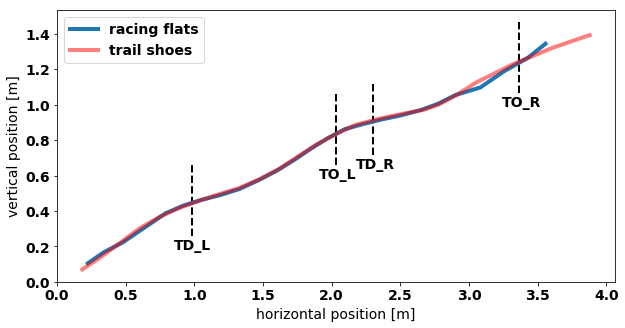

In [247]:
import matplotlib
font = {'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)


s = meter_per_pixel

coms_flat_scaled = coms_flat * meter_per_pixel
coms_trail_scaled = coms_trail * meter_per_pixel

yoff = 2.735
xoff = -1.455

coms_flat_scaled[:, 0] += xoff
coms_trail_scaled[:, 0] += xoff
coms_flat_scaled[:, 1] *= -1
coms_trail_scaled[:, 1] *= -1
coms_flat_scaled[:, 1] += yoff
coms_trail_scaled[:, 1] += yoff


plt.figure(figsize=(10, 5))
plt.plot(coms_flat_scaled[:, 0]+20*s, coms_flat_scaled[:, 1], label='racing flats', linewidth=4)
plt.plot(coms_trail_scaled[:, 0], coms_trail_scaled[:, 1], color='red', label='trail shoes', linewidth=4, alpha=.5)

# add time events.
events = {'TD_L': 6,
          'TO_L': 14,
          'TD_R': 16,
          'TO_R': 23,
        }

for k, v in events.items():
    x = coms_flat_scaled[v, 0] - .125
    y = coms_flat_scaled[v, 1] - .275
    plt.text(x, y, k)

vlines = np.array([coms_flat_scaled[t] for t in events.values()])

plt.vlines(vlines[:, 0], vlines[:, 1]-.2, vlines[:, 1]+.2, linestyles='--', linewidth=2)
plt.xlabel('horizontal position [m]')
plt.ylabel('vertical position [m]')
plt.legend()

plt.savefig('ksp.png')
None

In [308]:
def names_to_use():
    use_names = []
    for _, row in df_dempster.iterrows():
        p = row['proximal']
        d = row['distal']
        if row['sides'] == 2:
            use_names += [d+'.left', d+'.right', p+'.left', p+'.right']
        else:
            use_names += [d, p]
    return np.unique(use_names)

use_names = names_to_use()

# add time events.
events = {'TD_L': 6,
          'TO_L': 14,
          'TD_R': 16,
          'TO_R': 23,
          'slip': 10
        }

def plot_for_some_part(i, title=''):
    plt.figure(figsize=(10,4))
    body_part = use_names[i]
    hip_pts_trail = pts_trail[:, name_dict[body_part], :2]
    hip_pts = pts_flat[:, name_dict[body_part], :2]
    
    hip_pts_scaled = hip_pts * meter_per_pixel
    hip_pts_trail_scaled = hip_pts_trail * meter_per_pixel

    hip_pts_scaled[:, 0] += xoff
    hip_pts_trail_scaled[:, 0] += xoff
    hip_pts_scaled[:, 1] *= -1
    hip_pts_trail_scaled[:, 1] *= -1
    hip_pts_scaled[:, 1] += yoff
    hip_pts_trail_scaled[:, 1] += yoff

    vlines = np.array([coms_flat_scaled[t] for t in events.values()])
    print(body_part)
    yposs = []
    for v in vlines:
        xind = np.argmin(np.abs(hip_pts_scaled[:, 0]-v[0]))
        yposs.append(hip_pts_scaled[xind, 1])
    yposs = np.array(yposs)
    plt.vlines(vlines[:, 0], yposs-.5, yposs+.5, linestyles='--', linewidth=2)
    
    for ind, (k, v) in enumerate(events.items()):
        x = coms_flat_scaled[v, 0] - .125
        y = yposs[ind] + .6
        if k=='slip':
            c='red'
        else:
            c='black'
        plt.text(x, y, k, color=c)
    
    plt.plot(hip_pts_scaled[:, 0]+20*s, hip_pts_scaled[:, 1], color='cornflowerblue', 
             linewidth=3, label='flat', linestyle='--')
    plt.plot(hip_pts_trail_scaled[:, 0], hip_pts_trail_scaled[:, 1], color='red', 
             linewidth=3, label='trail', linestyle='--')
    
    plt.title(body_part)
    plt.xlabel('horizontal position [m]')
    plt.ylabel('vertical position [m]')
    plt.legend()
    plt.savefig('%s.png'%body_part)

ankle.left
wrist.left
wrist.right
elbow.left
elbow.right


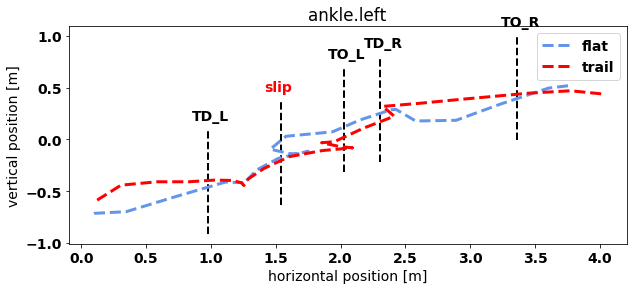

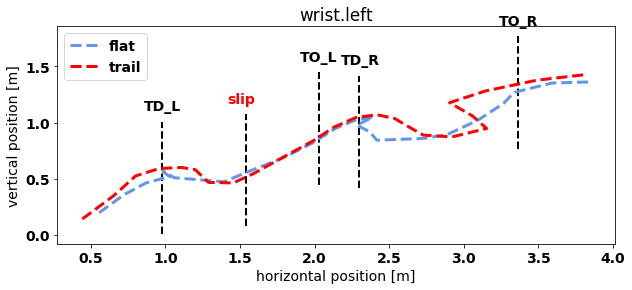

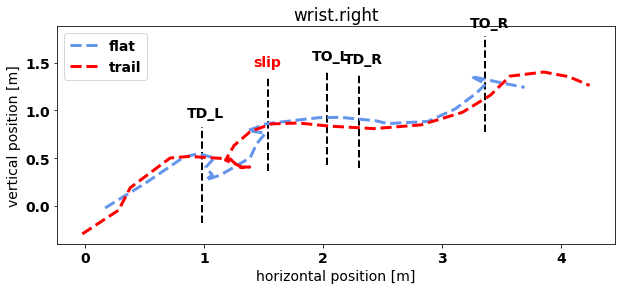

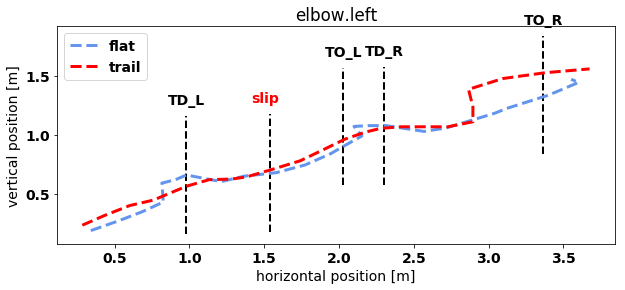

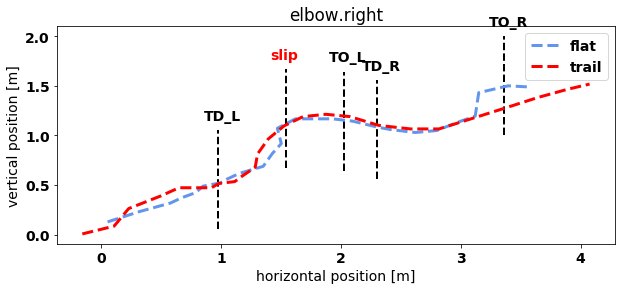

In [309]:
use_names = ['ankle.left', 'wrist.left', 'wrist.right', 'elbow.left', 'elbow.right']

for i in range(len(use_names)):
    plot_for_some_part(i)

In [305]:
# check out the knee angle
from collections import defaultdict

def compute_angles(p1='hip', p2='knee', p3='ankle'):
    angles = defaultdict(list)
    for side in ['left', 'right']:
        for name, smp in zip(['trail', 'flat'], [smooth_pts_flat, smooth_pts_trail]):
            for f in range(len(smp)):
                a = name_dict['%s.%s'%(p1, side)]
                b = name_dict['%s.%s'%(p2, side)]
                c = name_dict['%s.%s'%(p3, side)]

                A = smp[f, a, :]
                B = smp[f, b, :]
                C = smp[f, c, :]

                u = A - B
                v = C - B
                ang = np.degrees(np.arccos(np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))))
                angles['%s.%s'%(name, side)].append(ang)
    return angles

Text(0.5,1,'ankle angles')

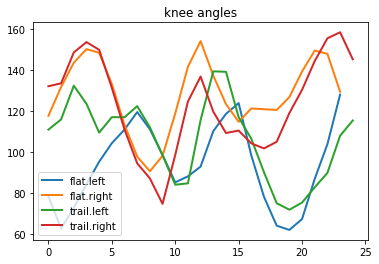

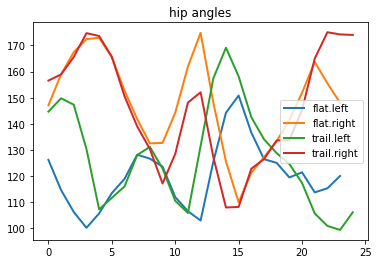

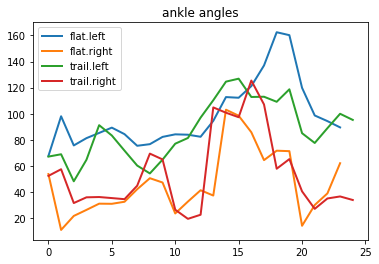

In [19]:
knee_angles = compute_angles()
hip_angles = compute_angles('shoulder', 'hip', 'knee')
ankle_angles = compute_angles('knee', 'ankle', 'bigtoe')

for k, v in sorted(knee_angles.items()):
    plt.plot(v, label=k, linewidth=2)
plt.legend()
plt.title('knee angles')

plt.figure()
for k, v in sorted(hip_angles.items()):
    plt.plot(v, label=k, linewidth=2)
plt.legend()
plt.title('hip angles')

plt.figure()
for k, v in sorted(ankle_angles.items()):
    plt.plot(v, label=k, linewidth=2)
plt.legend()
plt.title('ankle angles')

Text(0.5,1,'right ankle')

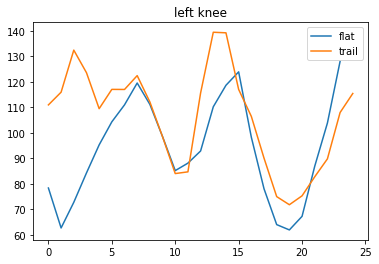

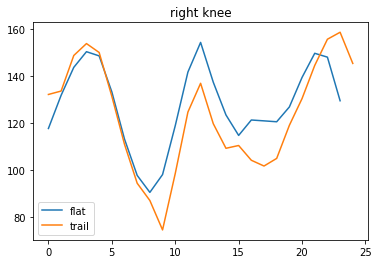

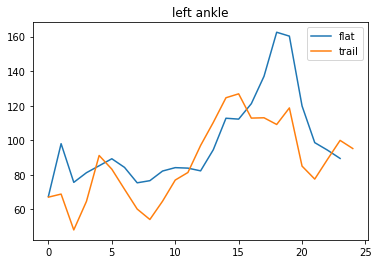

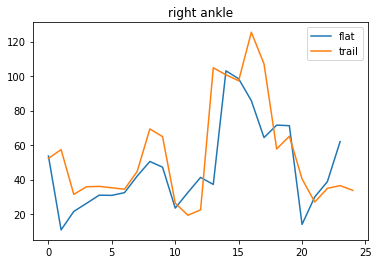

In [20]:
plt.plot(knee_angles['flat.left'], label='flat')
plt.plot(knee_angles['trail.left'], label='trail')
plt.legend()
plt.title('left knee')

plt.figure()
plt.plot(knee_angles['flat.right'], label='flat')
plt.plot(knee_angles['trail.right'], label='trail')
plt.legend()
plt.title('right knee')

plt.figure()
plt.plot(ankle_angles['flat.left'], label='flat')
plt.plot(ankle_angles['trail.left'], label='trail')
plt.legend()
plt.title('left ankle')

plt.figure()
plt.plot(ankle_angles['flat.right'], label='flat')
plt.plot(ankle_angles['trail.right'], label='trail')
plt.legend()
plt.title('right ankle')